## Analyze Overall Mondo Stats

This is a notebook for further data processing of SPARQL query results to generate stats about Mondo as requested [here](https://docs.google.com/document/d/1vPl2x8gfTypjzcb9ND8qXXfKIjPDE4RwuExmzAUpM6Q/edit?tab=t.0). 

Only requests for statistics that need further processing are included in the notebook. Details on how the statistics were generated for other requests are included in the README. 

The analysis file `exact_synonyms.tsv` was generated by running the query `get_exact_synonyms.ru` as:
```
robot reason -i ../../mondo-edit.obo query --use-graphs true -q sparql/get_exact_synonyms.ru data/output/exact_synonyms.tsv
```

### Request 7 - Synonyms
- Number of exact synonyms from each source
- Number of synonyms that have more than one source to show how many sources have overlapping synonyms

NOTE: 
- PMID can be grouped as “publication”
- ORCID and “ClinGen working group” can be grouped as “community submission”




In [1]:
# Imports
import pandas as pd

# Set pandas display options to show full column width
pd.set_option('display.max_colwidth', None)

In [2]:
# Read in sparql query results of all exact synonyms in Mondo for 
# terms that are children of MONDO:0700096 'human disease'

df_exact_synonyms = pd.read_csv('data/output/exact_synonyms.tsv', sep='\t')
df_exact_synonyms.head()

,?mondoCURIE,?mondoLabel,?exactSynonym,?exactSynonymXrefList
0,MONDO:0000004,adrenocortical insufficiency,adrenal cortical hypofunction,"NCIT:C26691, DOID:10493"
1,MONDO:0000004,adrenocortical insufficiency,adrenal cortical insufficiency,"NCIT:C26691, DOID:10493"
2,MONDO:0000004,adrenocortical insufficiency,adrenal gland insufficiency,"icd11.foundation:733056203, NCIT:C26691"
3,MONDO:0000004,adrenocortical insufficiency,adrenal insufficiency,"icd11.foundation:733056203, NCIT:C26691"
4,MONDO:0000004,adrenocortical insufficiency,adrenocortical insufficiency,"icd11.foundation:733056203, NCIT:C26691"


In [3]:
df_exact_synonyms.nunique()

?mondoCURIE              17817
?mondoLabel              17817
?exactSynonym            73029
?exactSynonymXrefList    29968
dtype: int64

---
Number of exact synonyms from each source
---

In [4]:
# Get a count of all distinct Sources found in the ?xrefList column

# Fill NaN values with an empty string to prevent iteration issues
df_exact_synonyms["?exactSynonymXrefList"] = df_exact_synonyms["?exactSynonymXrefList"].fillna("")

# Extract sources from ?xrefList
df_exact_synonyms["sources"] = df_exact_synonyms["?exactSynonymXrefList"].str.split(", ").apply(
    lambda x: [item.split(":")[0] for item in x if ":" in item]
)

# Flatten the list of sources and get value counts
source_counts = pd.Series([source for sources in df_exact_synonyms["sources"] for source in sources]).value_counts()

# Display the result
print(source_counts)

NCIT                20215
MONDO               18297
DOID                17968
Orphanet            13181
OMIM                10030
MONDORULE            2825
icd11.foundation     2606
https                1422
GARD                  912
MESH                  649
ICD10CM               540
ICD9CM                513
PMID                  446
NORD                  438
OMIMPS                265
MTH                   102
doi                    88
Wikipedia              72
SCTID                  57
UMLS                   53
DECIPHER               40
ONCOTREE               39
EFO                    34
OMOP                   24
GTR                    13
ISBN-13                12
HP                     11
http                    8
MedDRA                  5
MEDGEN                  5
ICD10WHO                2
OGMS                    1
ICD9                    1
MedGen                  1
SCDO                    1
Name: count, dtype: int64


#### NOTE: There are 4 Mondo terms that have an exact synonym that has 2 NCIT xrefs as provenance

- "MONDO:0001147"	"meningocele"	"meningocele"	"NCIT:C105595, NCIT:C101209, MONDO:ambiguous, DOID:1088"
- "MONDO:0002142"	"undifferentiated pleomorphic sarcoma"	"undifferentiated pleomorphic sarcoma"	"Orphanet:2023, NCIT:C4247, NCIT:C114541"
- "MONDO:0011655"	"alveolar soft part sarcoma"	"alveolar soft Part sarcoma"	"Orphanet:163699, OMIM:606243, NCIT:C7943, NCIT:C3750, DOID:4239"
- "MONDO:0011655"	"alveolar soft part sarcoma"	"alveolar soft part sarcoma"	"NCIT:C7943, NCIT:C3750, OMIM:606243, MONDO:ambiguous, Orphanet:163699, DOID:4239"


In [5]:
# Save to file
source_counts.to_csv('data/output/synonym_count_by_source.csv', sep='\t')

In [6]:
# Let's further explore the values where the "sources" column contains a value 
# that starts with 'http' or 'https'.

# Filter rows where '?xrefList' contains values starting with 'http' or 'https'
df_exact_synonyms_filtered = df_exact_synonyms[
    df_exact_synonyms["?exactSynonymXrefList"].str.contains(r"\bhttp|\bhttps", na=False)
].copy()


df_exact_synonyms_filtered.head()

,?mondoCURIE,?mondoLabel,?exactSynonym,?exactSynonymXrefList,sources
9,MONDO:0000015,classic complement early component deficiency,genetic deficiency of early component of the classical complement pathway,https://orcid.org/0000-0001-5208-3432,[https]
20,MONDO:0000050,isolated congenital growth hormone deficiency,ICGHD,https://orcid.org/0000-0002-6601-2165,[https]
30,MONDO:0000088,precocious puberty,pubertas praecox,https://rarediseases.org/rare-diseases/precocious-puberty/,[https]
31,MONDO:0000088,precocious puberty,sexual precocity,"https://rarediseases.org/rare-diseases/precocious-puberty/, NCIT:C79704, GARD:0007446","[https, NCIT, GARD]"
34,MONDO:0000107,auriculocondylar syndrome,auriculo-condylar syndrome,https://orcid.org/0000-0002-6601-2165,[https]


In [7]:
# Create a new column, urlSources, that contains a list of only source values that
# start with 'http' or 'https' so that the other source values are not included

df_exact_synonyms_filtered["urlSources"] = df_exact_synonyms_filtered["?exactSynonymXrefList"].apply(
    lambda x: [source.strip() for source in x.split(",") if source.strip().startswith(("http", "https"))]
)

df_exact_synonyms_filtered.head()

,?mondoCURIE,?mondoLabel,?exactSynonym,?exactSynonymXrefList,sources,urlSources
9,MONDO:0000015,classic complement early component deficiency,genetic deficiency of early component of the classical complement pathway,https://orcid.org/0000-0001-5208-3432,[https],[https://orcid.org/0000-0001-5208-3432]
20,MONDO:0000050,isolated congenital growth hormone deficiency,ICGHD,https://orcid.org/0000-0002-6601-2165,[https],[https://orcid.org/0000-0002-6601-2165]
30,MONDO:0000088,precocious puberty,pubertas praecox,https://rarediseases.org/rare-diseases/precocious-puberty/,[https],[https://rarediseases.org/rare-diseases/precocious-puberty/]
31,MONDO:0000088,precocious puberty,sexual precocity,"https://rarediseases.org/rare-diseases/precocious-puberty/, NCIT:C79704, GARD:0007446","[https, NCIT, GARD]",[https://rarediseases.org/rare-diseases/precocious-puberty/]
34,MONDO:0000107,auriculocondylar syndrome,auriculo-condylar syndrome,https://orcid.org/0000-0002-6601-2165,[https],[https://orcid.org/0000-0002-6601-2165]


In [8]:
# Save df_exact_synonyms_filtered to file to examine
df_exact_synonyms_filtered.to_csv('data/output/df_exact_synonyms_filtered.csv', index=False)

In [9]:
# Get a count of unique source values that start with 'http' or 'https' based on their domain value, e.g. 
# for https://www.merriam-webster.com/medical/communicable%20disease the domain value to
# count is https://www.merriam-webster.com/

# Function to extract base URL
def extract_base_url(url_list):
    if isinstance(url_list, list):
        return [url.split('/')[0] + '//' + url.split('/')[2] for url in url_list if url.startswith(("http://", "https://"))]
    return []

# Apply function and flatten the list
base_urls = df_exact_synonyms_filtered["urlSources"].apply(extract_base_url).explode()

# Count unique base URLs
unique_base_url_counts = base_urls.value_counts()

# Display the results as a DataFrame
result_df = unique_base_url_counts.reset_index().rename(columns={"index": "Base URL", 0: "Count"})

result_df.head(len(result_df))

,urlSources,count
0,https://orcid.org,873
1,https://clinicalgenome.org,178
2,https://www.clinicalgenome.org,119
3,https://www.ncbi.nlm.nih.gov,68
4,https://github.com,36
5,https://rarediseases.org,31
6,https://www.epilepsydiagnosis.org,22
7,https://www.circadiansleepdisorders.org,11
8,https://ghr.nlm.nih.gov,11
9,https://www.cdc.gov,9


In [10]:
# Save to file
result_df.to_csv('data/output/synonym_count_by_UrlSource.csv', sep='\t', index=False)

In [11]:
# DEBUG
# The count for https://orcid.org does not match the regex pattern count in mondo-edit.obo, the count
# is higher here. 

# Let's look at all rows that contain a value like 'https://orcid.org/' in df_exact_synonyms_filtered
# Filter rows where `urlSources` contains a value like 'https://orcid.org/'
filtered_df = df_exact_synonyms_filtered[df_exact_synonyms_filtered['urlSources'].apply(lambda x: any('https://orcid.org/' in url for url in x))]

filtered_df.head()

,?mondoCURIE,?mondoLabel,?exactSynonym,?exactSynonymXrefList,sources,urlSources
9,MONDO:0000015,classic complement early component deficiency,genetic deficiency of early component of the classical complement pathway,https://orcid.org/0000-0001-5208-3432,[https],[https://orcid.org/0000-0001-5208-3432]
20,MONDO:0000050,isolated congenital growth hormone deficiency,ICGHD,https://orcid.org/0000-0002-6601-2165,[https],[https://orcid.org/0000-0002-6601-2165]
34,MONDO:0000107,auriculocondylar syndrome,auriculo-condylar syndrome,https://orcid.org/0000-0002-6601-2165,[https],[https://orcid.org/0000-0002-6601-2165]
41,MONDO:0000129,glutaric aciduria,glutaric acidemia,https://orcid.org/0000-0002-6601-2165,[https],[https://orcid.org/0000-0002-6601-2165]
43,MONDO:0000129,glutaric aciduria,glutaric aciduria (disease),https://orcid.org/0000-0002-6601-2165,[https],[https://orcid.org/0000-0002-6601-2165]


In [12]:
# Save to file to examine
filtered_df.to_csv('data/output/orcid_only_urlSources.csv', index=False)

# REVIEW RESULT
# Reviewed data and the seemingly mismatch in counts is because there are some synonyms that have two Orcids
# so the regex pattern was not correct for this case. Simply searching with 'https://orcid.org' in the 
# 'orcid_only_urlSources.csv' file does give the same count as from the result_df above.

---
Number of synonyms that have more than one source to show how many sources have overlapping synonyms
---

In [13]:
# Get the number and plot the number of synonyms and their count of unique sources. 

df_exact_synonyms.head()

,?mondoCURIE,?mondoLabel,?exactSynonym,?exactSynonymXrefList,sources
0,MONDO:0000004,adrenocortical insufficiency,adrenal cortical hypofunction,"NCIT:C26691, DOID:10493","[NCIT, DOID]"
1,MONDO:0000004,adrenocortical insufficiency,adrenal cortical insufficiency,"NCIT:C26691, DOID:10493","[NCIT, DOID]"
2,MONDO:0000004,adrenocortical insufficiency,adrenal gland insufficiency,"icd11.foundation:733056203, NCIT:C26691","[icd11.foundation, NCIT]"
3,MONDO:0000004,adrenocortical insufficiency,adrenal insufficiency,"icd11.foundation:733056203, NCIT:C26691","[icd11.foundation, NCIT]"
4,MONDO:0000004,adrenocortical insufficiency,adrenocortical insufficiency,"icd11.foundation:733056203, NCIT:C26691","[icd11.foundation, NCIT]"


In [14]:
# Function to process sources
def extract_sources(xref_list):
    sources = []
    for xref in xref_list.split(", "):
        if "MONDO" in xref:
            # Keep Mondo values as they are
            sources.append(xref)
        elif xref.startswith("http") or xref.startswith("https"):
            # Keep the URL schema and domain up to the first slash after the domain
            domain = "/".join(xref.split("/")[:3])
            sources.append(domain)
        else:
            # Otherwise, split by ":" to get the source prefix
            sources.append(xref.split(":")[0])
    return sources

# Apply the function to create the new column
df_exact_synonyms["processed_sources"] = df_exact_synonyms["?exactSynonymXrefList"].apply(extract_sources)


df_exact_synonyms.head(len(df_exact_synonyms))

,?mondoCURIE,?mondoLabel,?exactSynonym,?exactSynonymXrefList,sources,processed_sources
0,MONDO:0000004,adrenocortical insufficiency,adrenal cortical hypofunction,"NCIT:C26691, DOID:10493","[NCIT, DOID]","[NCIT, DOID]"
1,MONDO:0000004,adrenocortical insufficiency,adrenal cortical insufficiency,"NCIT:C26691, DOID:10493","[NCIT, DOID]","[NCIT, DOID]"
2,MONDO:0000004,adrenocortical insufficiency,adrenal gland insufficiency,"icd11.foundation:733056203, NCIT:C26691","[icd11.foundation, NCIT]","[icd11.foundation, NCIT]"
3,MONDO:0000004,adrenocortical insufficiency,adrenal insufficiency,"icd11.foundation:733056203, NCIT:C26691","[icd11.foundation, NCIT]","[icd11.foundation, NCIT]"
4,MONDO:0000004,adrenocortical insufficiency,adrenocortical insufficiency,"icd11.foundation:733056203, NCIT:C26691","[icd11.foundation, NCIT]","[icd11.foundation, NCIT]"
...,...,...,...,...,...,...
73127,MONDO:8000018,benign paroxysmal positional vertigo,"vertigo, benign paroxysmal positional",OMIM:193007,[OMIM],[OMIM]
73128,MONDO:8000018,benign paroxysmal positional vertigo,"vertigo, benign recurrent","OMIM:193007, MONDO:Lexical","[OMIM, MONDO]","[OMIM, MONDO:Lexical]"
73129,MONDO:8000018,benign paroxysmal positional vertigo,"vestibulopathy, familial",OMIM:193007,[OMIM],[OMIM]
73130,MONDO:8000019,"vertigo, benign recurrent, 1",BRV1,,[],[]


In [15]:
# Replace lists containing only empty strings with empty lists so they will be counted as having length 0
df_exact_synonyms['processed_sources'] = df_exact_synonyms['processed_sources'].apply(
    lambda x: [] if isinstance(x, list) and all(val.strip() == '' for val in x) else x
)

# Count the number of sources in each row
df_exact_synonyms['num_sources'] = df_exact_synonyms['processed_sources'].apply(len)

# Check results
df_exact_synonyms[['processed_sources', 'num_sources']].head()

,processed_sources,num_sources
0,"[NCIT, DOID]",2
1,"[NCIT, DOID]",2
2,"[icd11.foundation, NCIT]",2
3,"[icd11.foundation, NCIT]",2
4,"[icd11.foundation, NCIT]",2


In [16]:
# Save to file
df_exact_synonyms.to_csv('data/output/df_exact_synonyms_processed-sources.csv', index=False)

In [17]:
# Plot a histogram of the number of synonyms an their count of sources

# Count the number of sources in each row
df_exact_synonyms['num_sources'] = df_exact_synonyms['processed_sources'].apply(len)

df_exact_synonyms['num_sources'].nunique()

8

In [18]:
# Count how many synonyms fall into each 'number of sources' bucket
source_counts = df_exact_synonyms['num_sources'].value_counts().sort_index()

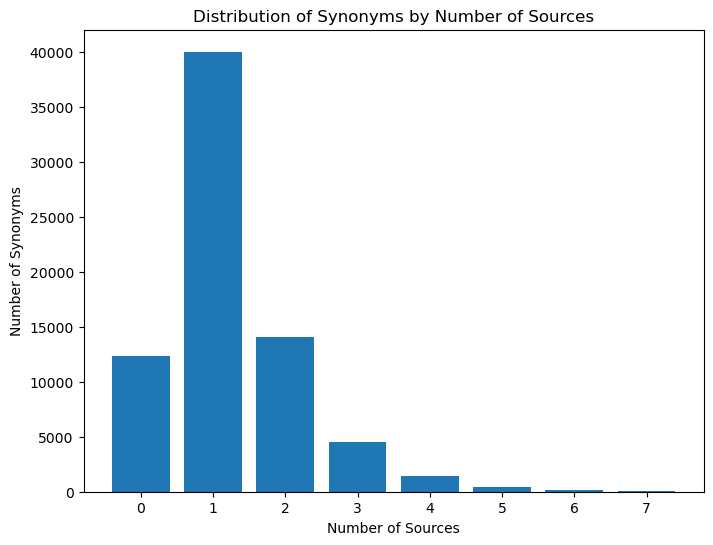

In [19]:
import matplotlib.pyplot as plt

# Plot a histogram of the counts
plt.figure(figsize=(8, 6))
plt.bar(source_counts.index, source_counts.values)
plt.xlabel('Number of Sources')
plt.ylabel('Number of Synonyms')
plt.title('Distribution of Synonyms by Number of Sources')
plt.xticks(source_counts.index)  # Set the x-ticks to align with the counts
plt.show()

In [20]:
# Save data to file
source_counts.to_csv('data/output/exact_synonym_source_distribution.csv', sep='\t', header=['Count'], index_label='Number of Sources')